# Fourier Transform Model of Image Formation

The Fourier transform (FT) transform is one among the many classes of linear transforms that recast information into a set of linear basis functions. In particular, FT converts a signal with  physical dimension $x$ into a signal with dimension $\frac{1}{x}$ using sinusoids as basis functions. If the signal has dimensions of space, the FT of the signal will have dimensions of inverse space or spatial frequency.

The 2D FFT has the following properties:
1. The output of FFT2 has quadrants along the diagonals interchanged. That is if the quadrants are labeled in the clockwise direction as $\begin{bmatrix} 4&1\\3&2 \end{bmatrix}$, the FFT output comes out as $\begin{bmatrix} 2&4\\1&3 \end{bmatrix}$. The function `fftshift()` interchanges the quadrants back.
2. The output of the FFT2 is a complex number array. To view the intensity, use `abs()` function which computes the modulus of the a complex number.
3. The inverse FFT2 , `ifft2()`, is just the same as the forward fft2( ) only that the output image may be upside down.

In [18]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont

plt.rcParams["figure.figsize"] = (4,4)
# plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

## Activity 2.1 - Familiarization with Discrete FT

In [29]:
def circular_aperture(radius, resolution):
    N = resolution
    x = np.linspace(-1, 1, N)
    y = x
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    aperture = np.zeros(np.shape(R))
    aperture = np.where((R<radius), 1, 0)
    
    return aperture

In [61]:
def aperture_fft(aperture_shape):
    fig, ax = plt.subplots(1, 3, figsize = (10, 5), sharey = True, tight_layout = True)
    ax[0].imshow(aperture_shape, cmap = "gray")
    ax[0].set_title("Circular aperture")
    
    fft_aperture = fft.fft2(aperture_shape)
    ax[1].imshow(abs(fft_aperture), cmap = "hot")
    ax[1].set_title("Fourier transform of aperture")
    
    fftshift_aperture = fft.fftshift(fft_aperture)
    ax[2].imshow(abs(fftshift_aperture), cmap = "hot")
    ax[2].set_title("Corrected quadrant positions")

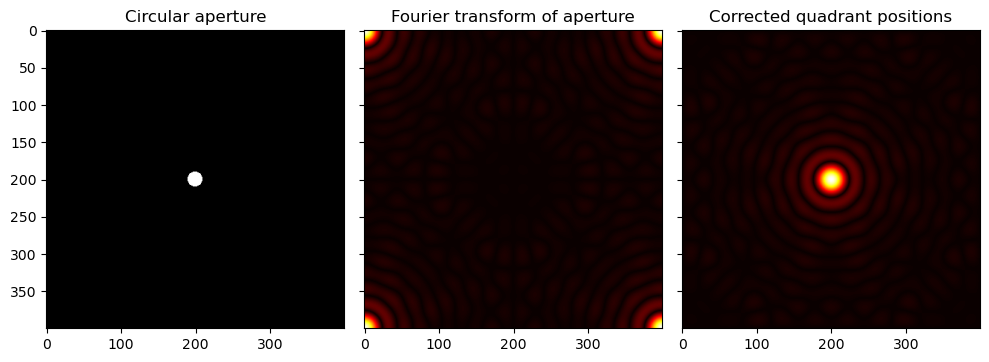

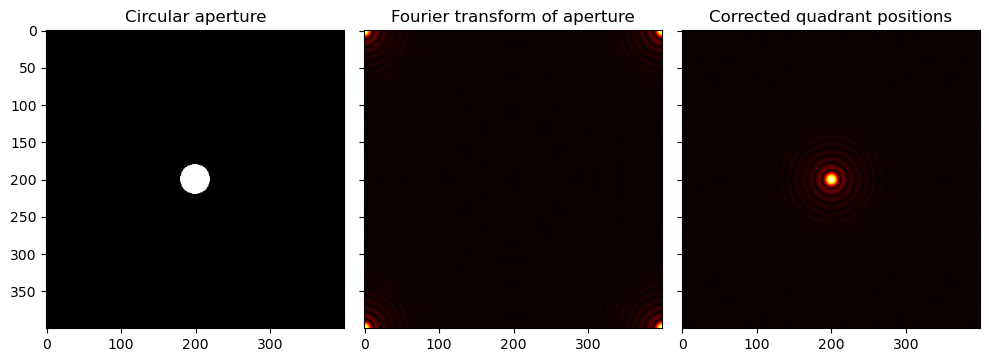

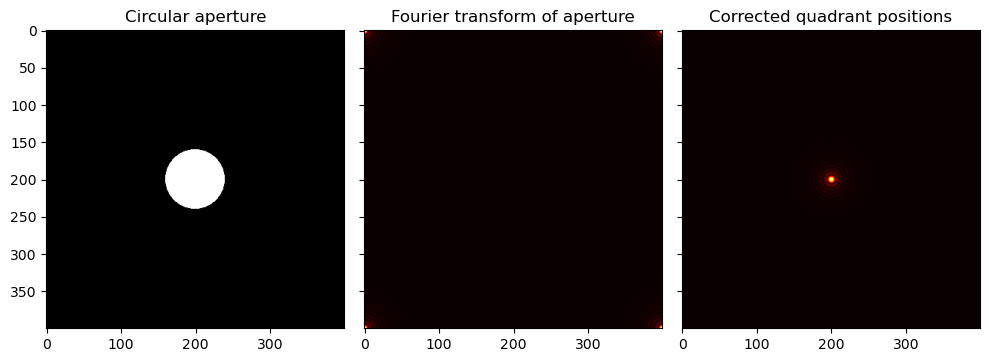

In [64]:
radius = [0.05, 0.1, 0.2]

for rad in radius:
    aperture_fft(circular_aperture(rad, 400))

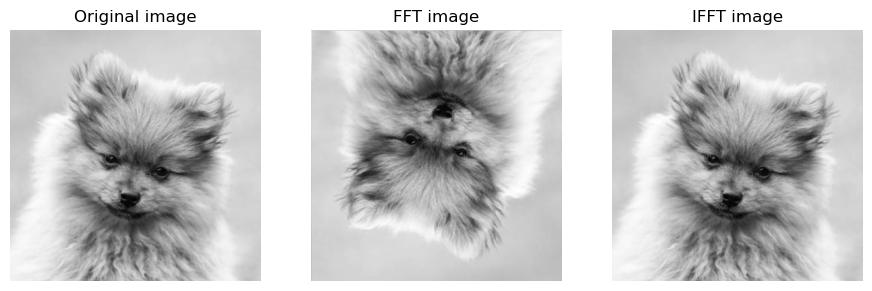

In [58]:
croppedimg = Image.open("cropped dog.png")
grayimg = np.array(croppedimg.convert("L"))

fft2_dog = fft.fft2(fft.fft2(grayimg))
ifft2_dog = fft.ifft2(fft.fft2(grayimg))

fig, ax = plt.subplots(1, 3, figsize = (11, 6), sharey = True)
ax[0].imshow(grayimg, cmap = "gray")
ax[0].set_title("Original image")
ax[1].imshow(abs(fft2_dog), cmap = "gray")
ax[1].set_title("FFT image")
ax[2].imshow(abs(ifft2_dog), cmap = "gray")
ax[2].set_title("IFFT image")

for i in range(3):
    ax[i].axis("off")